In [53]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [54]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [55]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
df_train = pd.read_csv("/content/drive/MyDrive/mnist_train.csv")
df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
X_train = df_train.drop('label', axis=1).values
y_train = df_train['label'].values

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
y_train = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [58]:
df_test_val = pd.read_csv("/content/drive/MyDrive/mnist_test.csv")
df_test_val.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_val, df_test = train_test_split(df_test_val, test_size=0.5, random_state=42)

X_val = df_val.drop('label', axis=1).values
y_val = df_val['label'].values

X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)
y_val = torch.tensor(y_val, dtype=torch.long)

dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [60]:
X_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28)
y_test = torch.tensor(y_test, dtype=torch.long)

dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [61]:
class CNN_dropout(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.dropout = nn.Dropout(rate)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1) # flattening the matrix
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [62]:
def trainCNN(Model):
    model = Model.to(device)
    lossType = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_losses = []
    val_losses = []

    for epoch in range(20):
      model.train()
      running_loss = 0
      #tupple of the inputs and their label
      for i, data in enumerate(train_loader,0):
        optimizer.zero_grad() #resetting gradients
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) #using gpu
        outputs = model(inputs) #forward propagation
        loss = lossType(outputs, labels)
        loss.backward() #backward propagation
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % 500 == 0 or (i + 1) % 999 == 0:
                print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.4f}")
                running_loss = 0.0

      avg_train_loss = running_loss / (i+1)
      train_losses.append(avg_train_loss)

      avg_val_loss = evaluateValLoss(model)
      val_losses.append(avg_val_loss)
    plot_losses(train_losses, val_losses)
    return model


In [63]:
def evaluateValLoss(model):
  total_loss=0
  samples=0
  model.eval()
  with torch.no_grad():
      for data in val_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device) #using gpu
          outputs = model(images)
          loss = nn.CrossEntropyLoss()(outputs,labels)
          total_loss += loss.item() * images.size(0)
          samples += images.size(0)

  final_loss = total_loss/samples
  return final_loss

In [64]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
def evaluateValCNN(model):
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            # returns max value & the indeces of the values
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100*correct)/total
    return accuracy

In [66]:
def evaluateTestCNN(model):
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100*correct)/total
    print(f"Accuracy: {accuracy}") #99.18 with momentum = 0.9, without 98.52 no droprate
    return accuracy

In [67]:
rates = [0, 0.1, 0.3, 0.5, 0.7] # 0 drop rate is no reg
def tuneDropOutRates(modelClass):
    accuracies = []
    for Rate in rates:
        modelType = modelClass(Rate)
        model = trainCNN(modelType)
        accuracy = evaluateValCNN(model)
        accuracies.append(accuracy)
    for i in range(len(accuracies)):
        print(f"For rate: {rates[i]} Accuracy = {accuracies[i]}\n")

#For rate: 0 Accuracy = 99.2
# For rate: 0.1 Accuracy = 98.9
# For rate: 0.3 Accuracy = 98.5
# For rate: 0.5 Accuracy = 97.68
# For rate: 0.7 Accuracy = 94.92

[Epoch 1, Batch 500] loss: 1.9592
[Epoch 2, Batch 500] loss: 0.3431
[Epoch 3, Batch 500] loss: 0.2326
[Epoch 4, Batch 500] loss: 0.1762
[Epoch 5, Batch 500] loss: 0.1432
[Epoch 6, Batch 500] loss: 0.1068
[Epoch 7, Batch 500] loss: 0.0911
[Epoch 8, Batch 500] loss: 0.0817
[Epoch 9, Batch 500] loss: 0.0666
[Epoch 10, Batch 500] loss: 0.0464
[Epoch 11, Batch 500] loss: 0.0428
[Epoch 12, Batch 500] loss: 0.0296
[Epoch 13, Batch 500] loss: 0.0317
[Epoch 14, Batch 500] loss: 0.0175
[Epoch 15, Batch 500] loss: 0.0140
[Epoch 16, Batch 500] loss: 0.0155
[Epoch 17, Batch 500] loss: 0.0199
[Epoch 18, Batch 500] loss: 0.0103
[Epoch 19, Batch 500] loss: 0.0044
[Epoch 20, Batch 500] loss: 0.0024


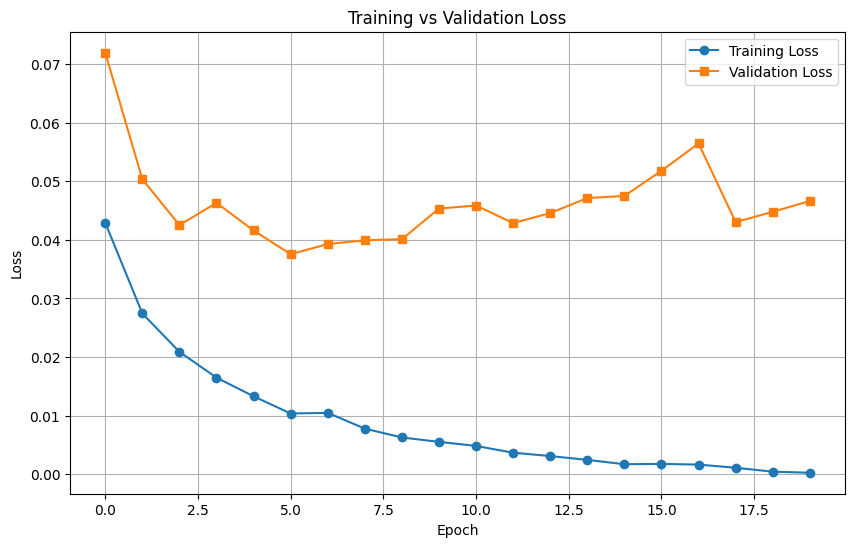

[Epoch 1, Batch 500] loss: 1.7817
[Epoch 2, Batch 500] loss: 0.4077
[Epoch 3, Batch 500] loss: 0.2965
[Epoch 4, Batch 500] loss: 0.2294
[Epoch 5, Batch 500] loss: 0.1811
[Epoch 6, Batch 500] loss: 0.1550
[Epoch 7, Batch 500] loss: 0.1514
[Epoch 8, Batch 500] loss: 0.1303
[Epoch 9, Batch 500] loss: 0.1063
[Epoch 10, Batch 500] loss: 0.1018
[Epoch 11, Batch 500] loss: 0.0953
[Epoch 12, Batch 500] loss: 0.0798
[Epoch 13, Batch 500] loss: 0.0685
[Epoch 14, Batch 500] loss: 0.0820
[Epoch 15, Batch 500] loss: 0.0641
[Epoch 16, Batch 500] loss: 0.0551
[Epoch 17, Batch 500] loss: 0.0467
[Epoch 18, Batch 500] loss: 0.0459
[Epoch 19, Batch 500] loss: 0.0373
[Epoch 20, Batch 500] loss: 0.0418


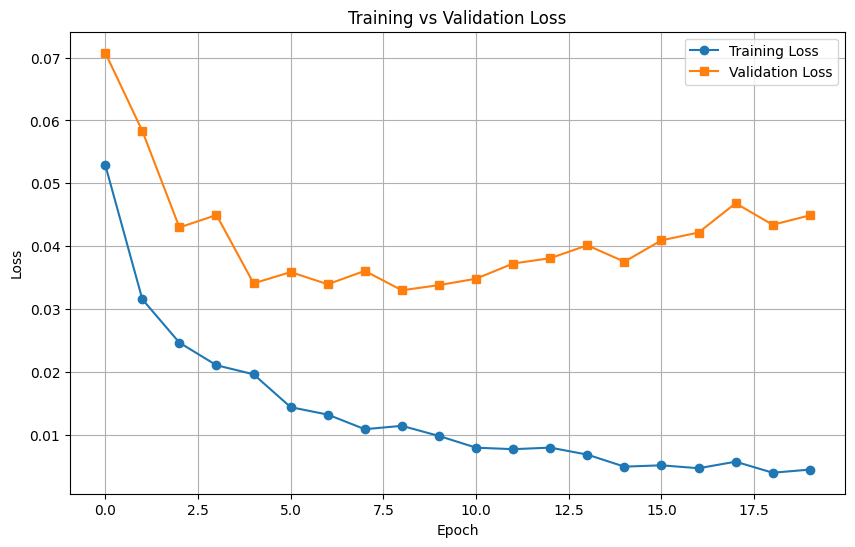

[Epoch 1, Batch 500] loss: 4.0059
[Epoch 2, Batch 500] loss: 0.5570
[Epoch 3, Batch 500] loss: 0.4324
[Epoch 4, Batch 500] loss: 0.3407
[Epoch 5, Batch 500] loss: 0.2970
[Epoch 6, Batch 500] loss: 0.2624
[Epoch 7, Batch 500] loss: 0.2517
[Epoch 8, Batch 500] loss: 0.2172
[Epoch 9, Batch 500] loss: 0.2023
[Epoch 10, Batch 500] loss: 0.2039
[Epoch 11, Batch 500] loss: 0.1894
[Epoch 12, Batch 500] loss: 0.1684
[Epoch 13, Batch 500] loss: 0.1608
[Epoch 14, Batch 500] loss: 0.1445
[Epoch 15, Batch 500] loss: 0.1468
[Epoch 16, Batch 500] loss: 0.1521
[Epoch 17, Batch 500] loss: 0.1443
[Epoch 18, Batch 500] loss: 0.1346
[Epoch 19, Batch 500] loss: 0.1296
[Epoch 20, Batch 500] loss: 0.1075


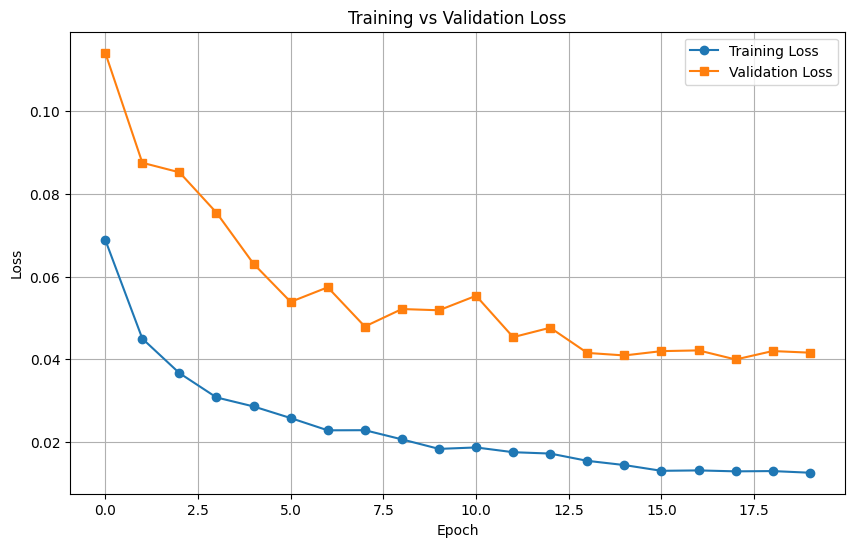

[Epoch 1, Batch 500] loss: 3.5718
[Epoch 2, Batch 500] loss: 0.8555
[Epoch 3, Batch 500] loss: 0.6990
[Epoch 4, Batch 500] loss: 0.5946
[Epoch 5, Batch 500] loss: 0.5088
[Epoch 6, Batch 500] loss: 0.4642
[Epoch 7, Batch 500] loss: 0.4368
[Epoch 8, Batch 500] loss: 0.4065
[Epoch 9, Batch 500] loss: 0.3740
[Epoch 10, Batch 500] loss: 0.3684
[Epoch 11, Batch 500] loss: 0.3531
[Epoch 12, Batch 500] loss: 0.3408
[Epoch 13, Batch 500] loss: 0.3232
[Epoch 14, Batch 500] loss: 0.3338
[Epoch 15, Batch 500] loss: 0.2984
[Epoch 16, Batch 500] loss: 0.3062
[Epoch 17, Batch 500] loss: 0.2882
[Epoch 18, Batch 500] loss: 0.3009
[Epoch 19, Batch 500] loss: 0.2867
[Epoch 20, Batch 500] loss: 0.2815


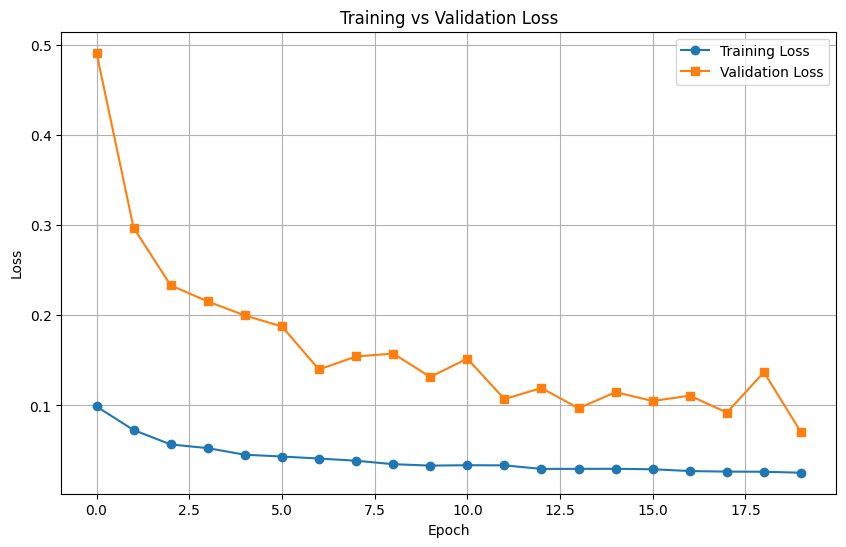

[Epoch 1, Batch 500] loss: 4.5236
[Epoch 2, Batch 500] loss: 1.4064
[Epoch 3, Batch 500] loss: 1.2361
[Epoch 4, Batch 500] loss: 1.0820
[Epoch 5, Batch 500] loss: 0.9922
[Epoch 6, Batch 500] loss: 0.9601
[Epoch 7, Batch 500] loss: 0.9205
[Epoch 8, Batch 500] loss: 0.8872
[Epoch 9, Batch 500] loss: 0.8482
[Epoch 10, Batch 500] loss: 0.8425
[Epoch 11, Batch 500] loss: 0.8511
[Epoch 12, Batch 500] loss: 0.7958
[Epoch 13, Batch 500] loss: 0.8038
[Epoch 14, Batch 500] loss: 0.8015
[Epoch 15, Batch 500] loss: 0.7512
[Epoch 16, Batch 500] loss: 0.7914
[Epoch 17, Batch 500] loss: 0.7639
[Epoch 18, Batch 500] loss: 0.7444
[Epoch 19, Batch 500] loss: 0.7413
[Epoch 20, Batch 500] loss: 0.7380


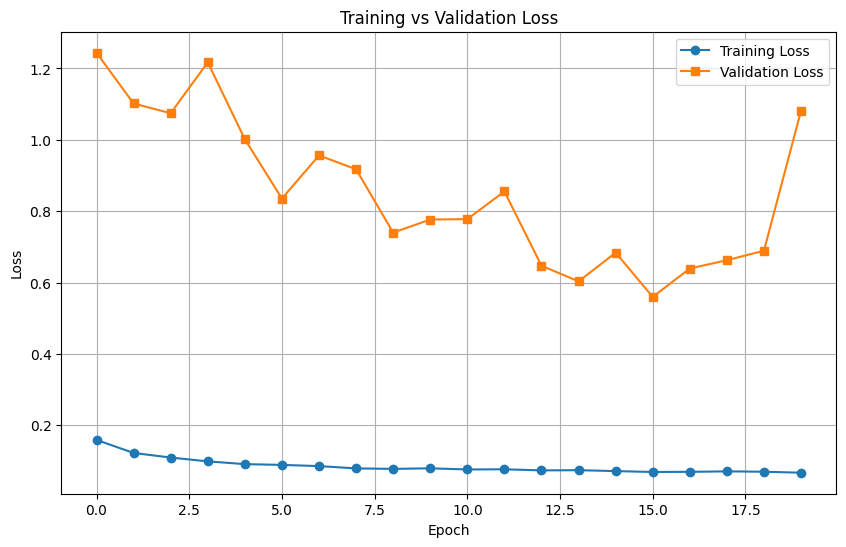

For rate: 0 Accuracy = 98.92

For rate: 0.1 Accuracy = 98.64

For rate: 0.3 Accuracy = 98.64

For rate: 0.5 Accuracy = 98.44

For rate: 0.7 Accuracy = 91.8



In [68]:
tuneDropOutRates(modelClass=CNN_dropout)

In [69]:
class CNN_batchNormalization(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.dropout = nn.Dropout(rate)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

[Epoch 1, Batch 500] loss: 3.0607
[Epoch 2, Batch 500] loss: 0.5602
[Epoch 3, Batch 500] loss: 0.4029
[Epoch 4, Batch 500] loss: 0.3243
[Epoch 5, Batch 500] loss: 0.2618
[Epoch 6, Batch 500] loss: 0.2416
[Epoch 7, Batch 500] loss: 0.2305
[Epoch 8, Batch 500] loss: 0.1903
[Epoch 9, Batch 500] loss: 0.1843
[Epoch 10, Batch 500] loss: 0.1740
[Epoch 11, Batch 500] loss: 0.1663
[Epoch 12, Batch 500] loss: 0.1426
[Epoch 13, Batch 500] loss: 0.1471
[Epoch 14, Batch 500] loss: 0.1296
[Epoch 15, Batch 500] loss: 0.1183
[Epoch 16, Batch 500] loss: 0.1218
[Epoch 17, Batch 500] loss: 0.1076
[Epoch 18, Batch 500] loss: 0.1068
[Epoch 19, Batch 500] loss: 0.0968
[Epoch 20, Batch 500] loss: 0.0932


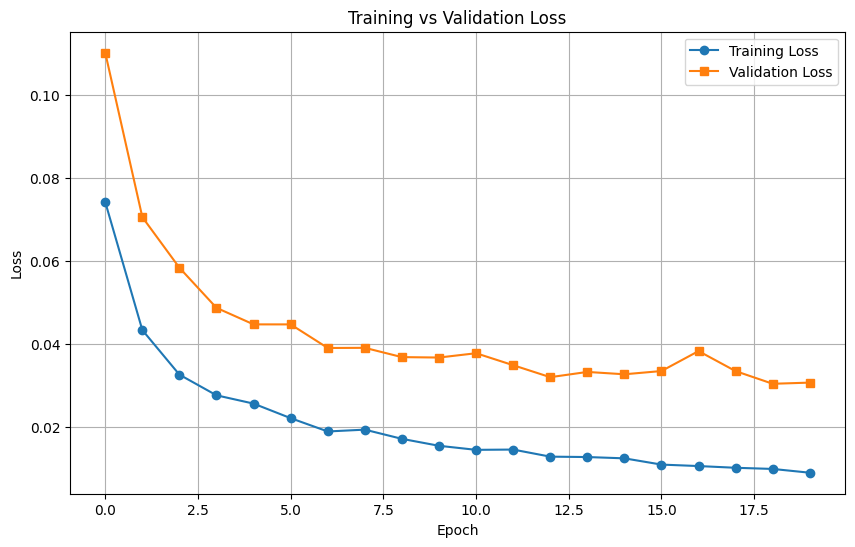

[Epoch 1, Batch 500] loss: 3.4031
[Epoch 2, Batch 500] loss: 0.7382
[Epoch 3, Batch 500] loss: 0.5286
[Epoch 4, Batch 500] loss: 0.4371
[Epoch 5, Batch 500] loss: 0.3763
[Epoch 6, Batch 500] loss: 0.3361
[Epoch 7, Batch 500] loss: 0.3089
[Epoch 8, Batch 500] loss: 0.2835
[Epoch 9, Batch 500] loss: 0.2697
[Epoch 10, Batch 500] loss: 0.2502
[Epoch 11, Batch 500] loss: 0.2407
[Epoch 12, Batch 500] loss: 0.2368
[Epoch 13, Batch 500] loss: 0.2193
[Epoch 14, Batch 500] loss: 0.2104
[Epoch 15, Batch 500] loss: 0.1943
[Epoch 16, Batch 500] loss: 0.1833
[Epoch 17, Batch 500] loss: 0.1741
[Epoch 18, Batch 500] loss: 0.1723
[Epoch 19, Batch 500] loss: 0.1680
[Epoch 20, Batch 500] loss: 0.1623


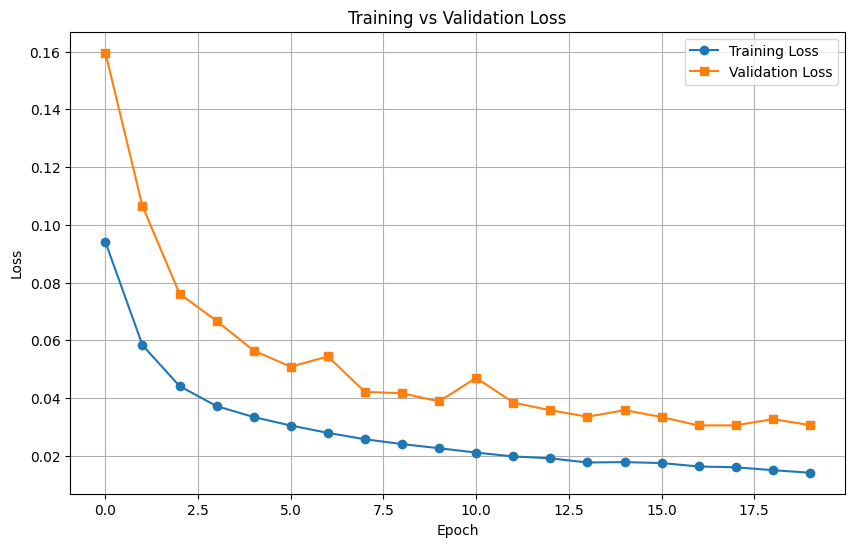

[Epoch 1, Batch 500] loss: 3.6658
[Epoch 2, Batch 500] loss: 1.0047
[Epoch 3, Batch 500] loss: 0.7014
[Epoch 4, Batch 500] loss: 0.5822
[Epoch 5, Batch 500] loss: 0.4958
[Epoch 6, Batch 500] loss: 0.4521
[Epoch 7, Batch 500] loss: 0.3959
[Epoch 8, Batch 500] loss: 0.3806
[Epoch 9, Batch 500] loss: 0.3488
[Epoch 10, Batch 500] loss: 0.3398
[Epoch 11, Batch 500] loss: 0.3108
[Epoch 12, Batch 500] loss: 0.2818
[Epoch 13, Batch 500] loss: 0.2875
[Epoch 14, Batch 500] loss: 0.2796
[Epoch 15, Batch 500] loss: 0.2655
[Epoch 16, Batch 500] loss: 0.2517
[Epoch 17, Batch 500] loss: 0.2356
[Epoch 18, Batch 500] loss: 0.2300
[Epoch 19, Batch 500] loss: 0.2347
[Epoch 20, Batch 500] loss: 0.2194


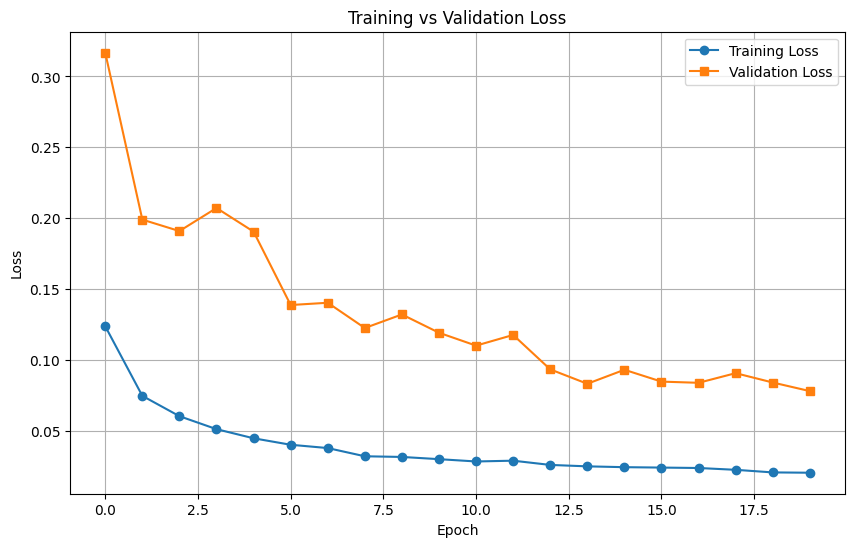

[Epoch 1, Batch 500] loss: 3.9915
[Epoch 2, Batch 500] loss: 1.2242
[Epoch 3, Batch 500] loss: 0.9100
[Epoch 4, Batch 500] loss: 0.7498
[Epoch 5, Batch 500] loss: 0.6812
[Epoch 6, Batch 500] loss: 0.6176
[Epoch 7, Batch 500] loss: 0.5559
[Epoch 8, Batch 500] loss: 0.5410
[Epoch 9, Batch 500] loss: 0.5030
[Epoch 10, Batch 500] loss: 0.4589
[Epoch 11, Batch 500] loss: 0.4599
[Epoch 12, Batch 500] loss: 0.4479
[Epoch 13, Batch 500] loss: 0.4249
[Epoch 14, Batch 500] loss: 0.4148
[Epoch 15, Batch 500] loss: 0.3979
[Epoch 16, Batch 500] loss: 0.3828
[Epoch 17, Batch 500] loss: 0.3827
[Epoch 18, Batch 500] loss: 0.3828
[Epoch 19, Batch 500] loss: 0.3547
[Epoch 20, Batch 500] loss: 0.3572


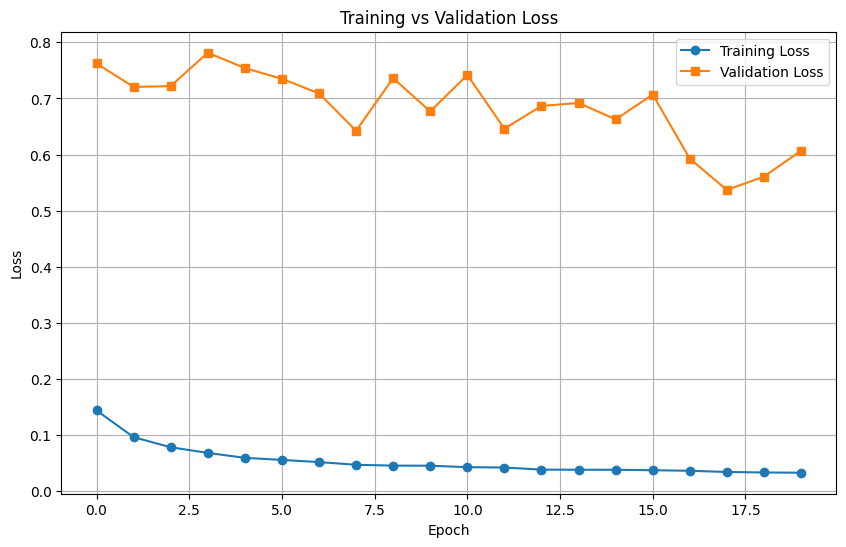

[Epoch 1, Batch 500] loss: 4.7144
[Epoch 2, Batch 500] loss: 1.8570
[Epoch 3, Batch 500] loss: 1.4556
[Epoch 4, Batch 500] loss: 1.2899
[Epoch 5, Batch 500] loss: 1.0963
[Epoch 6, Batch 500] loss: 1.0360
[Epoch 7, Batch 500] loss: 0.9721
[Epoch 8, Batch 500] loss: 0.9384
[Epoch 9, Batch 500] loss: 0.8850
[Epoch 10, Batch 500] loss: 0.8644
[Epoch 11, Batch 500] loss: 0.8375
[Epoch 12, Batch 500] loss: 0.8250
[Epoch 13, Batch 500] loss: 0.7861
[Epoch 14, Batch 500] loss: 0.7677
[Epoch 15, Batch 500] loss: 0.7331
[Epoch 16, Batch 500] loss: 0.7571
[Epoch 17, Batch 500] loss: 0.7270
[Epoch 18, Batch 500] loss: 0.7238
[Epoch 19, Batch 500] loss: 0.6932
[Epoch 20, Batch 500] loss: 0.6728


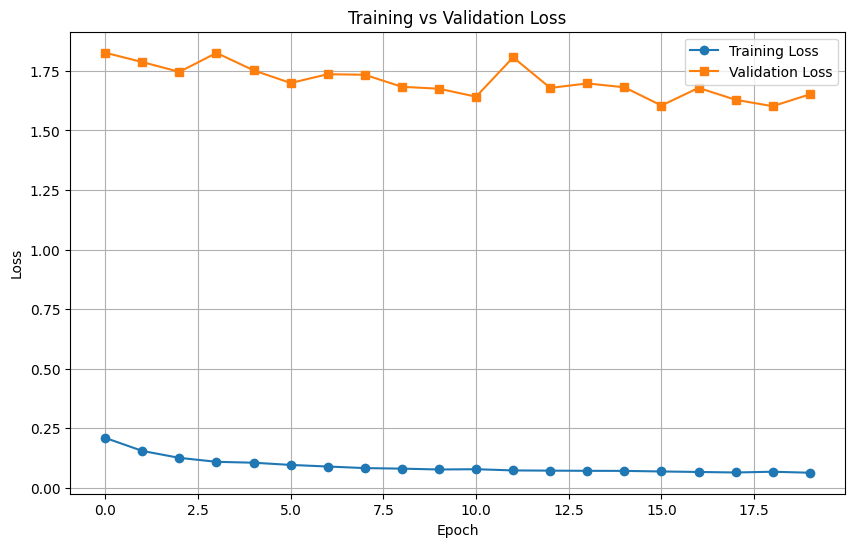

For rate: 0 Accuracy = 99.08

For rate: 0.1 Accuracy = 99.04

For rate: 0.3 Accuracy = 98.18

For rate: 0.5 Accuracy = 82.38

For rate: 0.7 Accuracy = 44.1



In [70]:
tuneDropOutRates(modelClass=CNN_batchNormalization)
# For rate: 0 Accuracy = 99.12
# For rate: 0.1 Accuracy = 98.94
# For rate: 0.3 Accuracy = 98.74
# For rate: 0.5 Accuracy = 97.62
# For rate: 0.7 Accuracy = 95.84

[Epoch 1, Batch 500] loss: 1.7677
[Epoch 2, Batch 500] loss: 0.3239
[Epoch 3, Batch 500] loss: 0.2252
[Epoch 4, Batch 500] loss: 0.1848
[Epoch 5, Batch 500] loss: 0.1611
[Epoch 6, Batch 500] loss: 0.1268
[Epoch 7, Batch 500] loss: 0.1011
[Epoch 8, Batch 500] loss: 0.0940
[Epoch 9, Batch 500] loss: 0.0856
[Epoch 10, Batch 500] loss: 0.0726
[Epoch 11, Batch 500] loss: 0.0577
[Epoch 12, Batch 500] loss: 0.0396
[Epoch 13, Batch 500] loss: 0.0485
[Epoch 14, Batch 500] loss: 0.0300
[Epoch 15, Batch 500] loss: 0.0256
[Epoch 16, Batch 500] loss: 0.0259
[Epoch 17, Batch 500] loss: 0.0157
[Epoch 18, Batch 500] loss: 0.0249
[Epoch 19, Batch 500] loss: 0.0125
[Epoch 20, Batch 500] loss: 0.0141


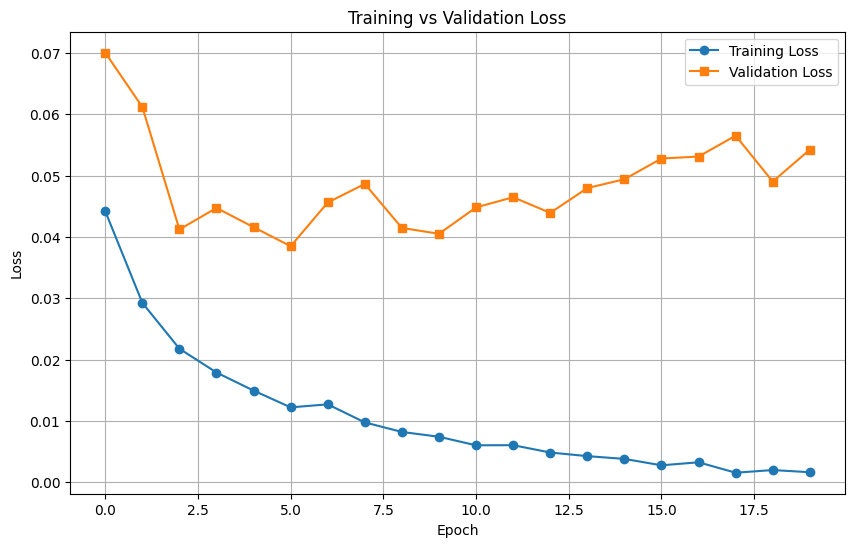

[Epoch 1, Batch 500] loss: 3.6379
[Epoch 2, Batch 500] loss: 0.9496
[Epoch 3, Batch 500] loss: 0.6899
[Epoch 4, Batch 500] loss: 0.5890
[Epoch 5, Batch 500] loss: 0.4887
[Epoch 6, Batch 500] loss: 0.4649
[Epoch 7, Batch 500] loss: 0.3889
[Epoch 8, Batch 500] loss: 0.3880
[Epoch 9, Batch 500] loss: 0.3595
[Epoch 10, Batch 500] loss: 0.3427
[Epoch 11, Batch 500] loss: 0.3338
[Epoch 12, Batch 500] loss: 0.3113
[Epoch 13, Batch 500] loss: 0.2914
[Epoch 14, Batch 500] loss: 0.2839
[Epoch 15, Batch 500] loss: 0.2743
[Epoch 16, Batch 500] loss: 0.2529
[Epoch 17, Batch 500] loss: 0.2570
[Epoch 18, Batch 500] loss: 0.2579
[Epoch 19, Batch 500] loss: 0.2428
[Epoch 20, Batch 500] loss: 0.2230


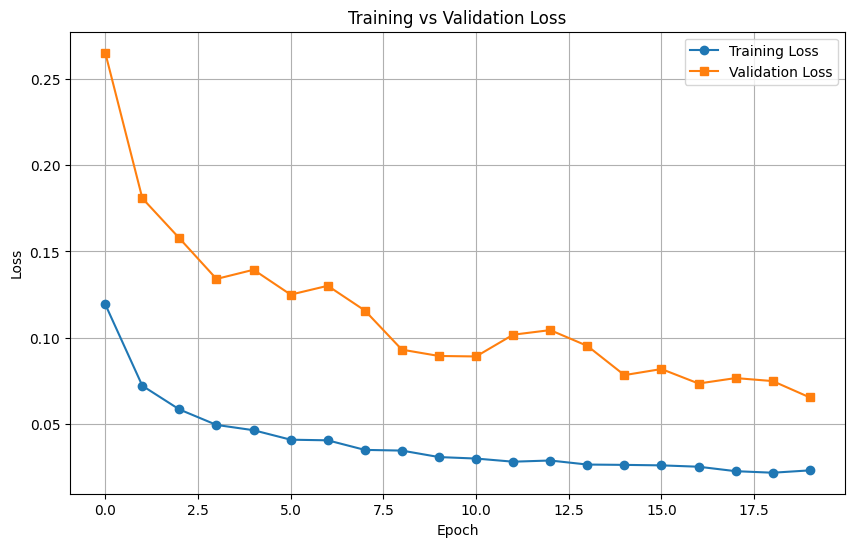

Accuracy: 98.62
98.62
Accuracy: 98.06
98.06


In [72]:
model_no_normalization = trainCNN(CNN_dropout(rate=0))
model_normalization = trainCNN(CNN_batchNormalization(rate=0.3))
print(evaluateTestCNN(model_no_normalization))
print(evaluateTestCNN(model_normalization))